In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.0 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 pynndescent==0.5.7


In [3]:
from utils import enrich

In [4]:
adata = sc.read('2301_annot_patient_integrated_ambient_removed.h5ad')
# adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211015_annot_patient_integrated.h5ad')
# adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/220128_annot_patient_integrated_scanorama.h5ad')
adata = adata[adata.obs.treatment != 'nan']
adata

View of AnnData object with n_obs × n_vars = 181660 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', 'leiden_coarse', 'leiden_fine', 'leiden_subset', 'celltype_fine', 'celltype_approx', 'ambient'
    var: 'used_for_scvi'
    uns: '_scvi', 'cell_type_colors', 'celltype_approx_colors', 'celltype_coarse_colors', 'celltype_fine_colors', 'dendrogram_leiden_fine', 'hvg', 'infected_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'leiden_fine_colors', 'neighbors', 'patient_colors', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Train a classifier on infection vs. non-infection in the mock sample.

In [5]:
adata[adata.obs['treatment'] == 'mock'].shape

(26059, 18115)

In [6]:
%%time
clf = LogisticRegression(solver='saga')
clf.fit(
    adata[adata.obs['treatment'] == 'mock'].X.toarray(),
    adata[adata.obs['treatment'] == 'mock'].obs['infected'].values
)

CPU times: user 4min 55s, sys: 700 ms, total: 4min 55s
Wall time: 4min 56s


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [7]:
# performance on training
clf.score(
    adata[adata.obs['treatment'] == 'mock'].X.toarray(),
    adata[adata.obs['treatment'] == 'mock'].obs['infected'].values
)

0.8840707625004797

(It's overfit, but unclear by how much without a holdout.)

#### Intepret weights.

/tmp/ipykernel_2596354/2084239736.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['logreg_coef'] = clf.coef_[0]


Text(0.5, 1.0, 'logistic regression weights per gene')

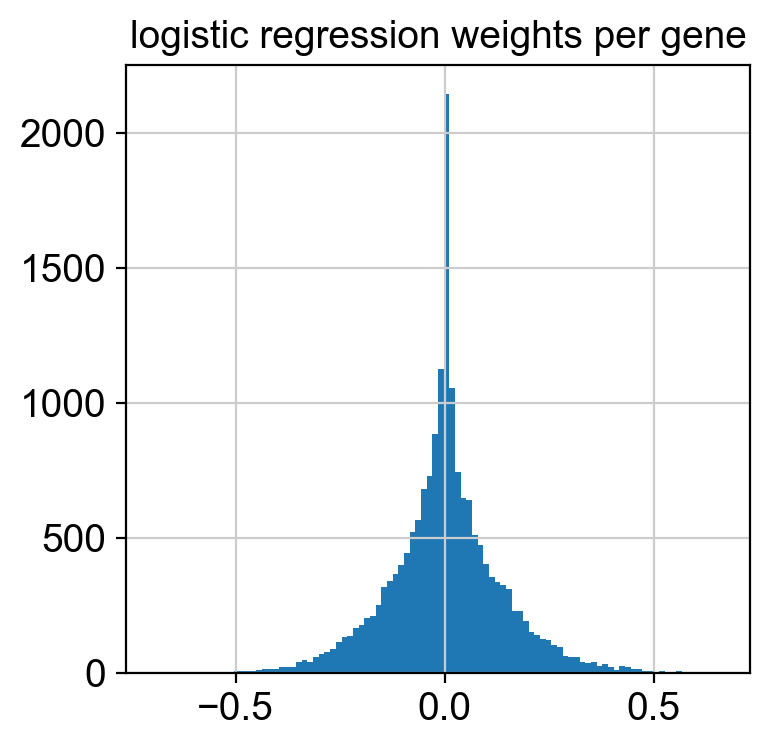

In [8]:
adata.var['logreg_coef'] = clf.coef_[0]
plt.hist(clf.coef_[0], bins=100)
plt.title('logistic regression weights per gene')

In [16]:
neg = adata.var_names[adata.var['logreg_coef'] < -.4]
pos = adata.var_names[adata.var['logreg_coef'] > .4]
enrich(list(neg) + list(pos), background=adata.var_names).head(10)

Empty DataFrame
Columns: [name, p_value, intersections]
Index: []

### Use these weights to score conditions

In [43]:
# performance on drug: should be low for drugs that did more
scores = {}
for status in ['True', 'False']:
    subset = adata[adata.obs['infected'] == status]
    for t in subset.obs.treatment.cat.categories:
        if status == 'True':
            scores[f'{t}-{status}'] = -.5 + clf.score(
                subset[subset.obs['treatment'] == t].X.toarray(),
                subset[subset.obs['treatment'] == t].obs['infected'].values
            )
        else:
            scores[f'{t}-{status}'] = .5 - clf.score(
                subset[subset.obs['treatment'] == t].X.toarray(),
                subset[subset.obs['treatment'] == t].obs['infected'].values
            )

In [60]:
df = pd.DataFrame.from_dict(scores, orient='index').reset_index()
df['treatment'] = [v.split('-')[0] for v in df['index']]
df['infected'] = [v.split('-')[1] for v in df['index']]
df = df.drop('index', axis=1)
# df[[0]] += 0.375308

Text(0.5, 0, 'recapitulation of immune\nresponse to infection')

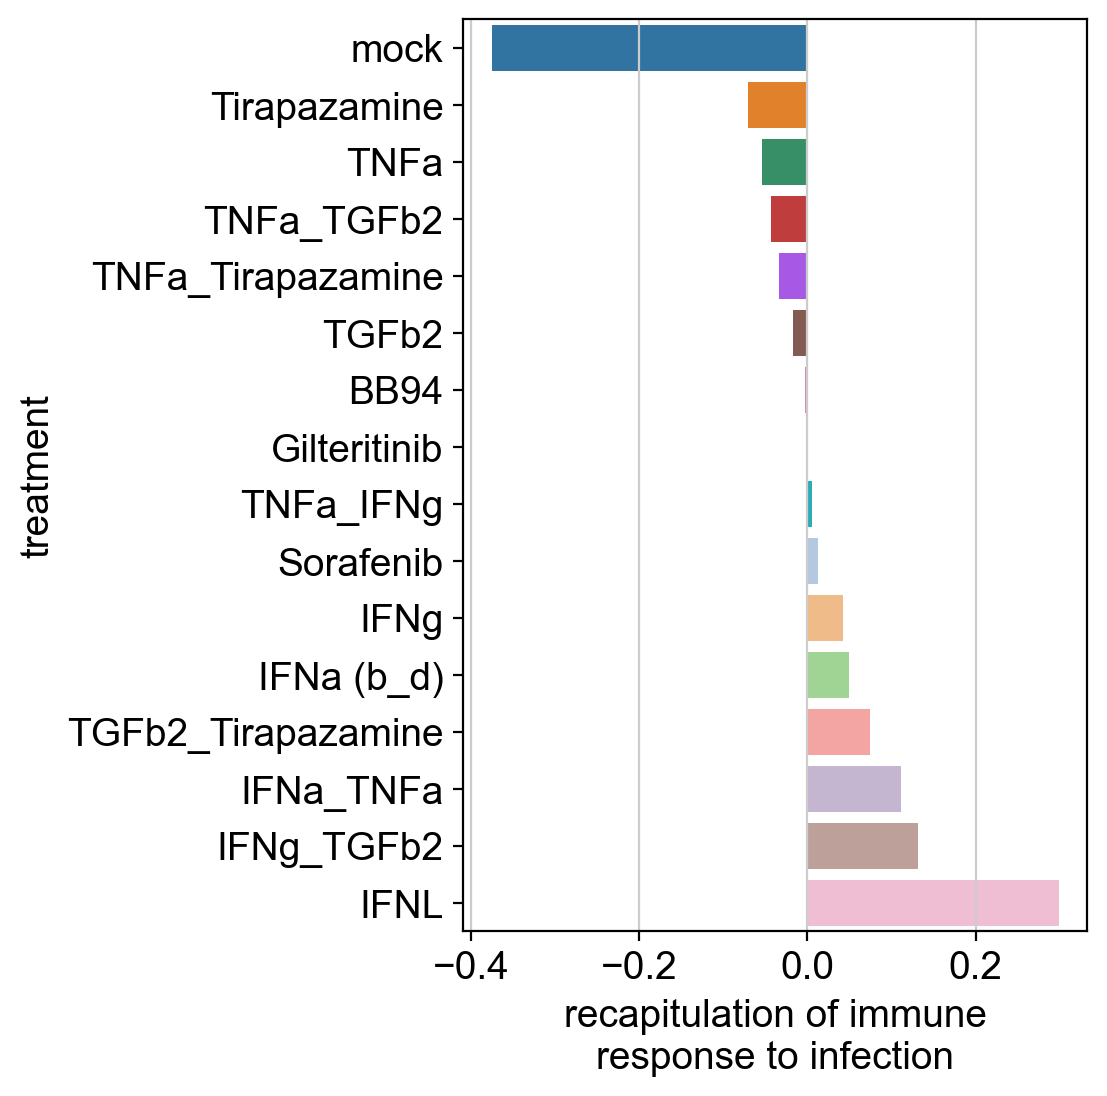

In [66]:
plt.figure(figsize=(4, 6))
sns.barplot(data=df[df.infected == 'False'].sort_values(by=0), x=0, y='treatment')
plt.xlabel('recapitulation of immune\nresponse to infection')

Text(0.5, 0, 'does the population look infected')

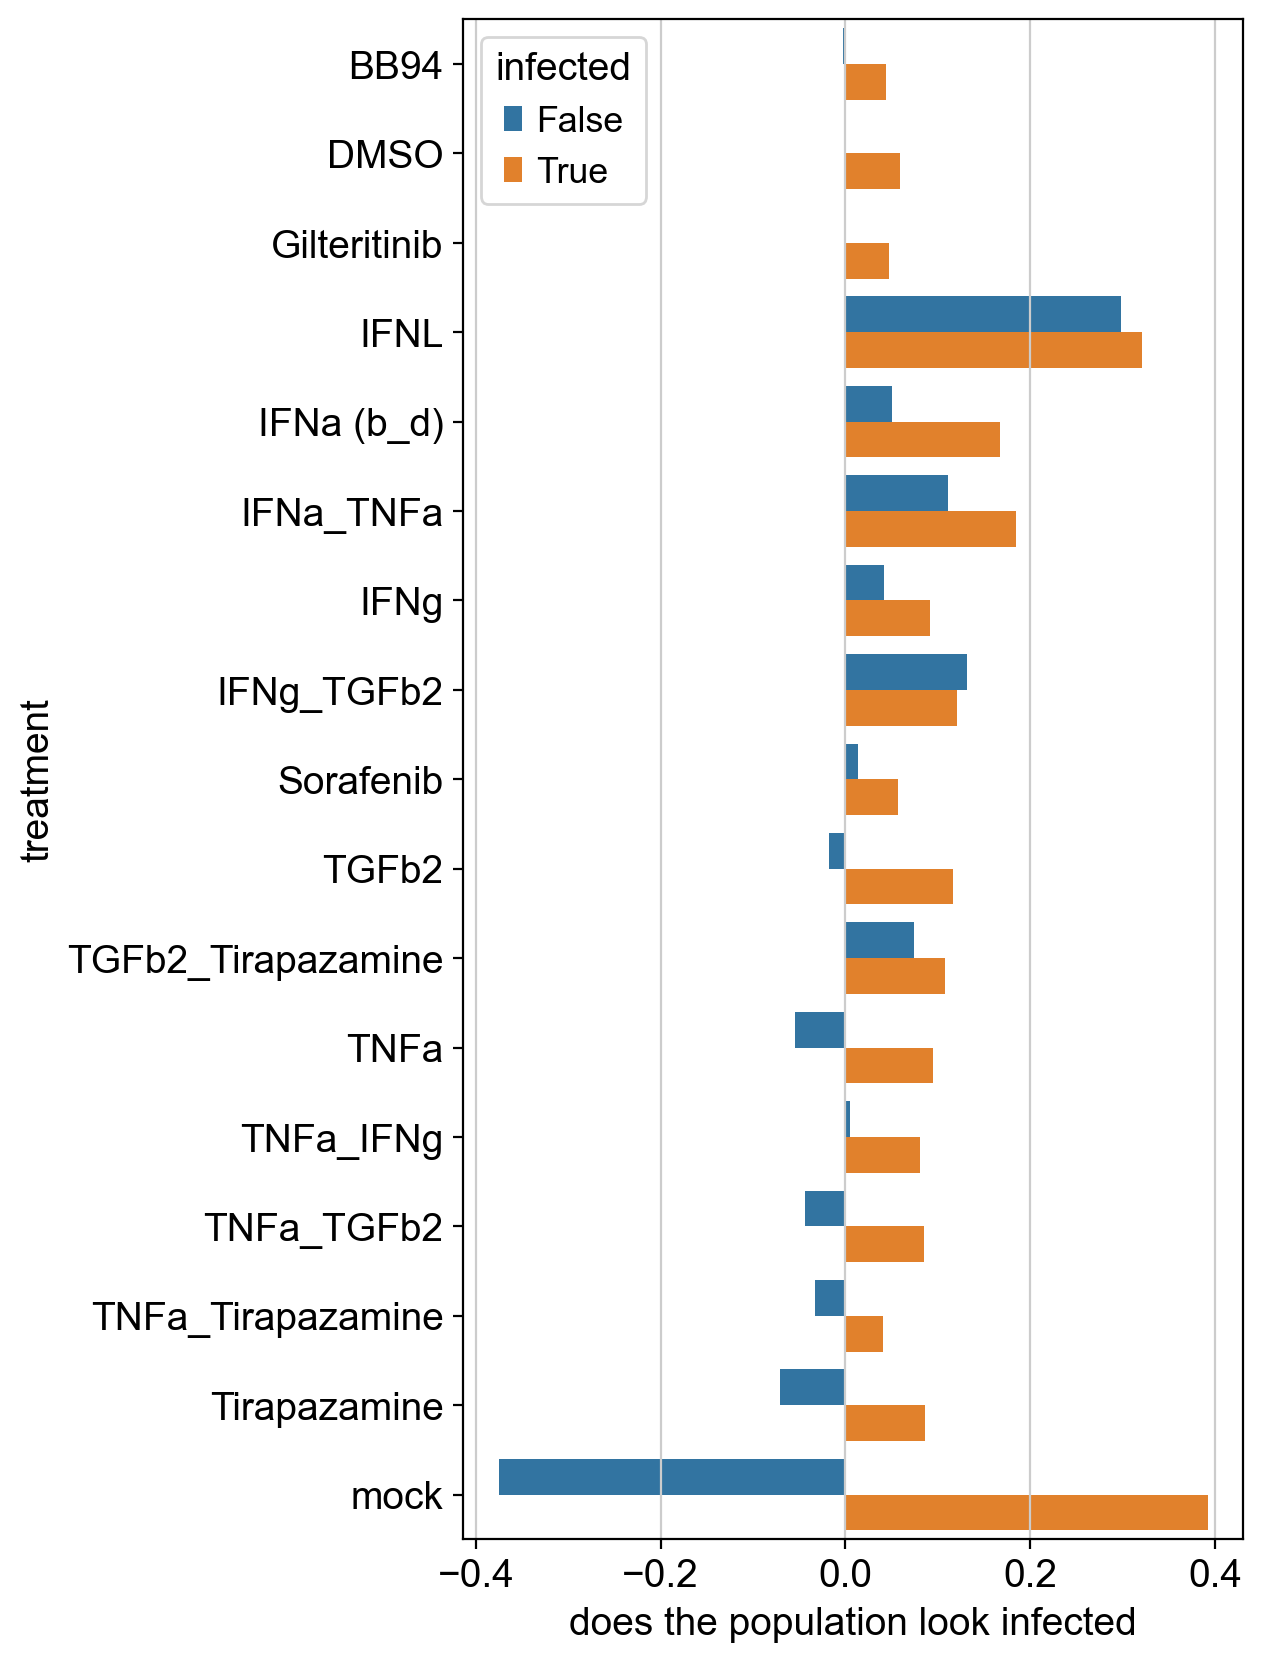

In [18]:
df = pd.DataFrame.from_dict(scores, orient='index').reset_index()
df['treatment'] = [v.split('-')[0] for v in df['index']]
df['infected'] = [v.split('-')[1] for v in df['index']]
df = df.drop('index', axis=1)

plt.figure(figsize=(5, 10))
sns.barplot(data=df, x=0, y='treatment', hue='infected', hue_order=['False', 'True'])
plt.xlabel('does the population look infected')

Check: does this match the average differences in viral load between treatment and control for these samples? Yes! (TODO)

In [19]:
%%time
pred = clf.predict_proba(adata.X.toarray())

CPU times: user 15.5 s, sys: 7.11 s, total: 22.6 s
Wall time: 5.96 s


In [20]:
adata.obs['probability_False'] = pred[:, 0]
adata.obs['probability_True'] = pred[:, 1]

In [22]:
# replicate Meshal's pretty plotting colors
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

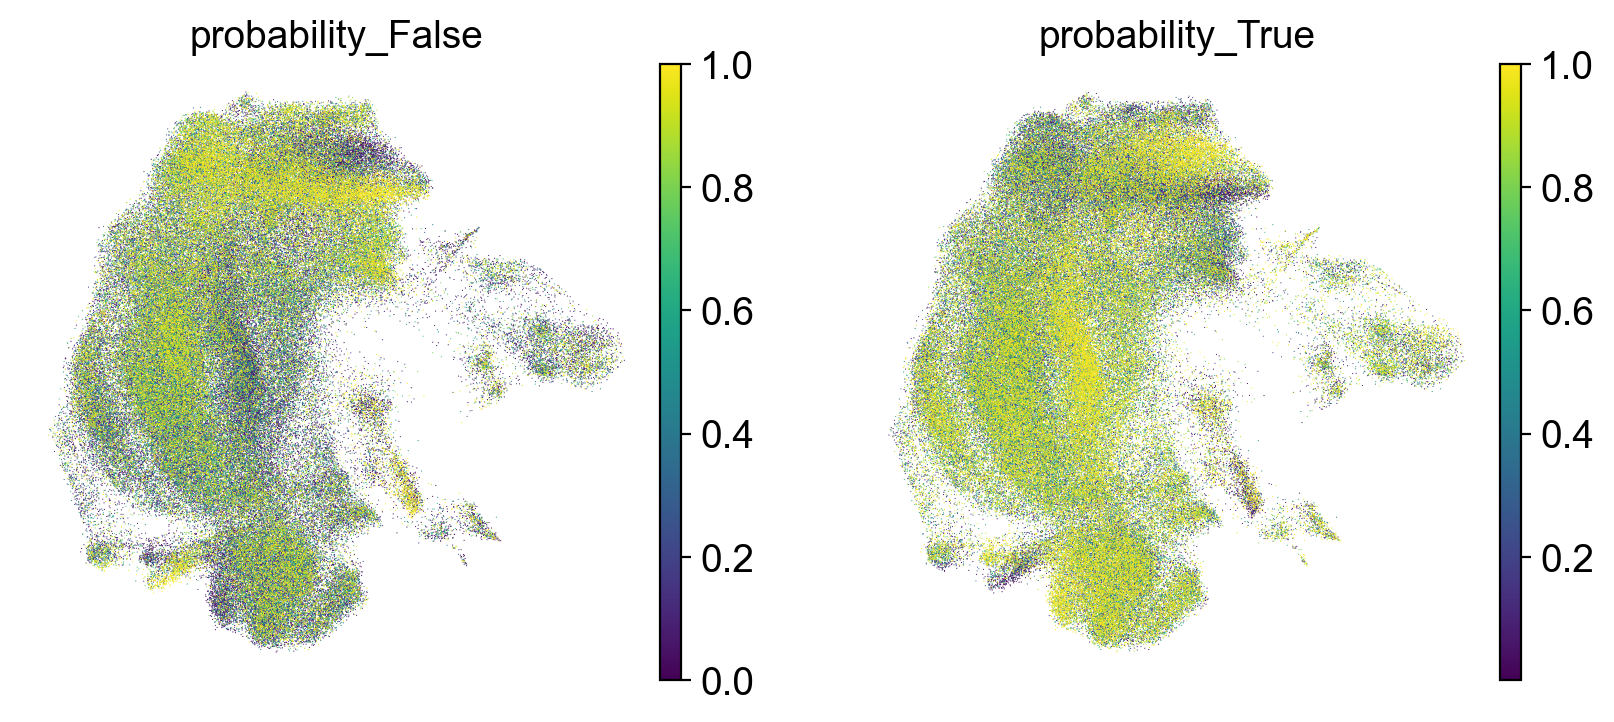

In [24]:
sc.pl.umap(adata, color=['probability_False', 'probability_True'], cmap='viridis')

In [25]:
df = adata.obs.copy()

In [34]:
# plt.figure(figsize=(5, 10))
# sns.barplot(data=df, x='probability_False', y='treatment', hue='infected')

Which cell types responded to infection:

/tmp/ipykernel_2596354/1754517124.py:4: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


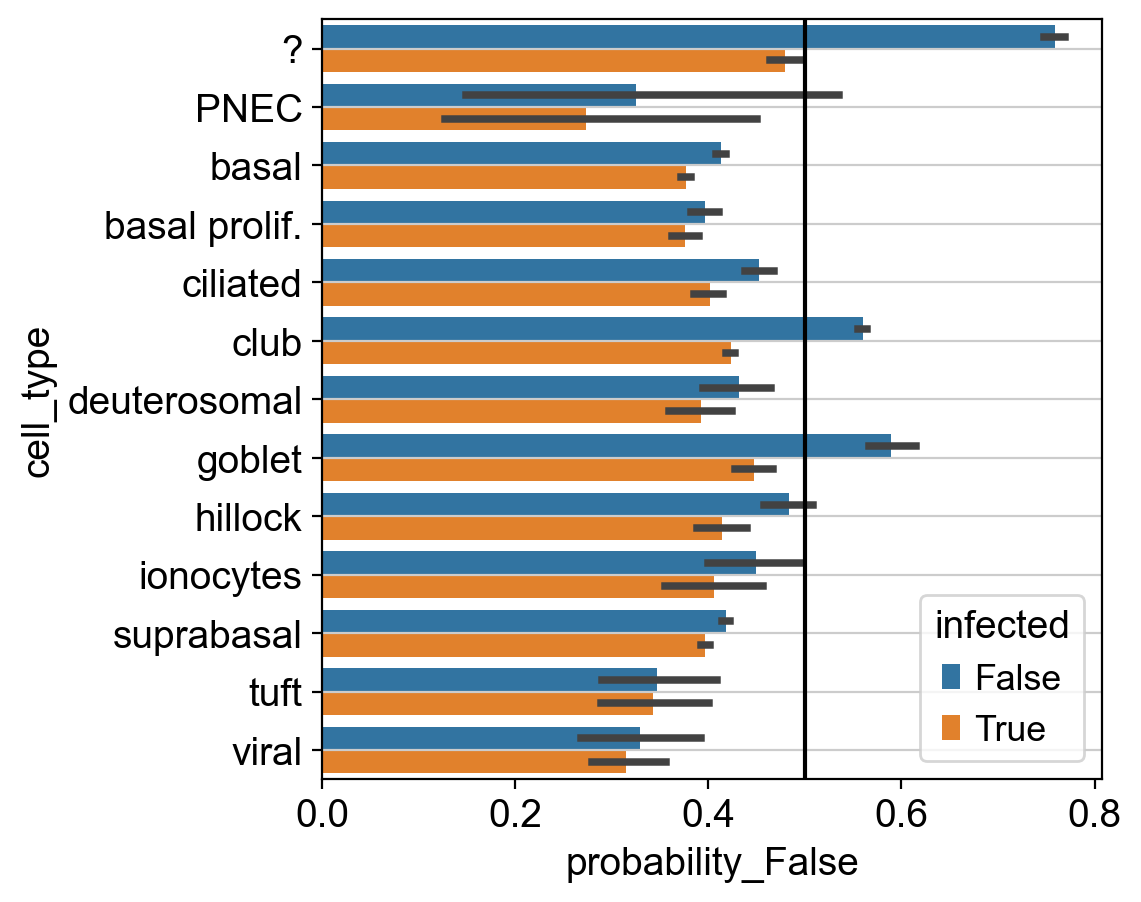

In [40]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df[df.treatment != 'mock'], x='probability_False', y='cell_type', hue='infected')
plt.axvline(.5, c='black')
plt.grid(b=None)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping

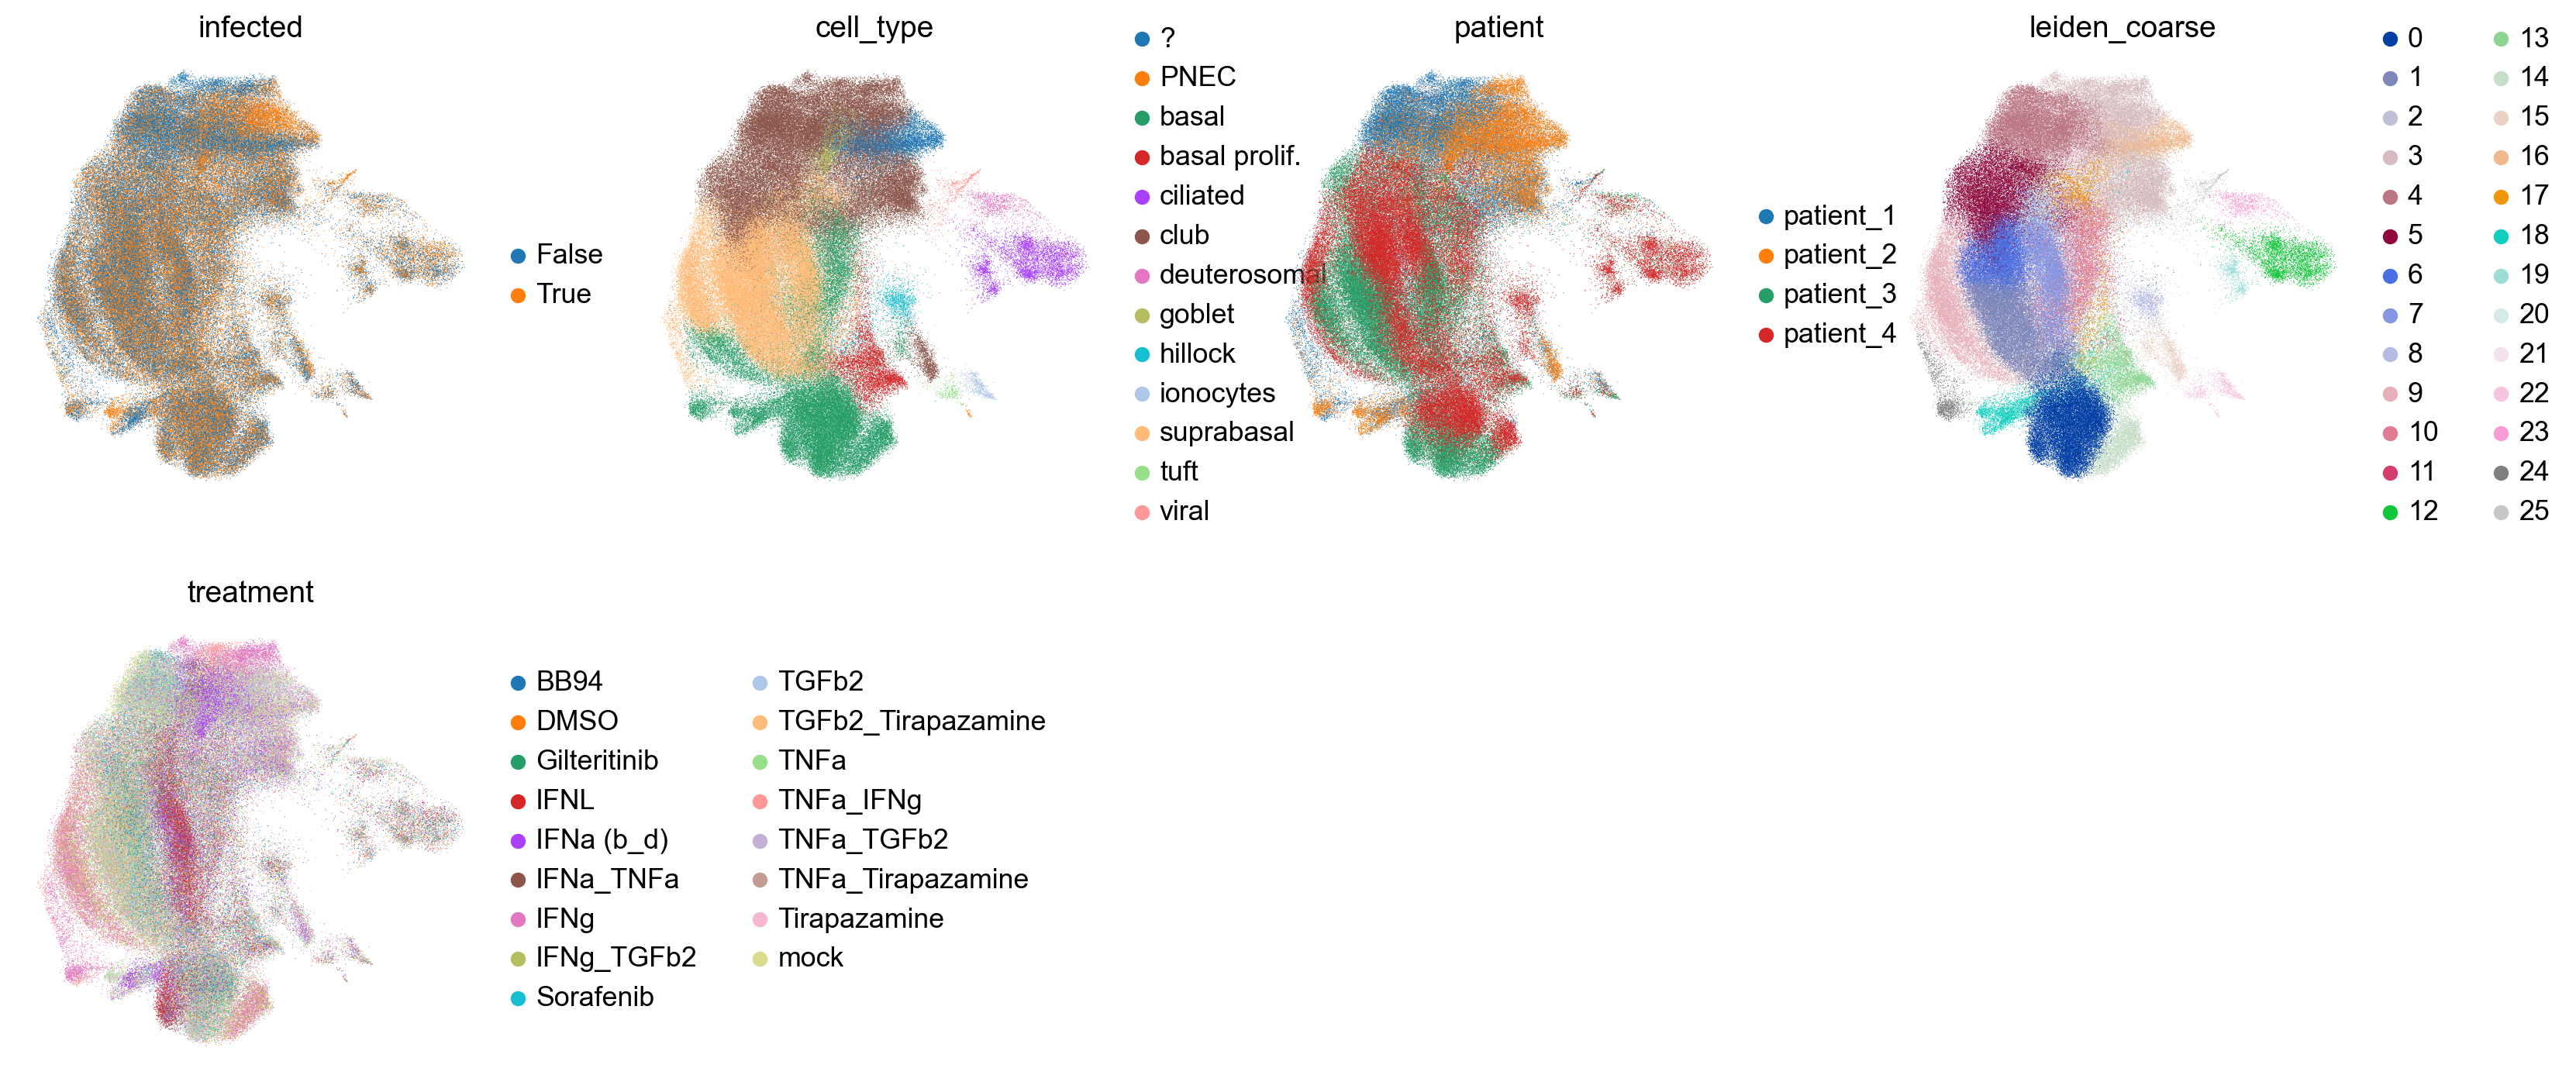

In [32]:
sc.pl.umap(adata, color=['infected', 'cell_type', 'patient', 'leiden_coarse', 'treatment'])

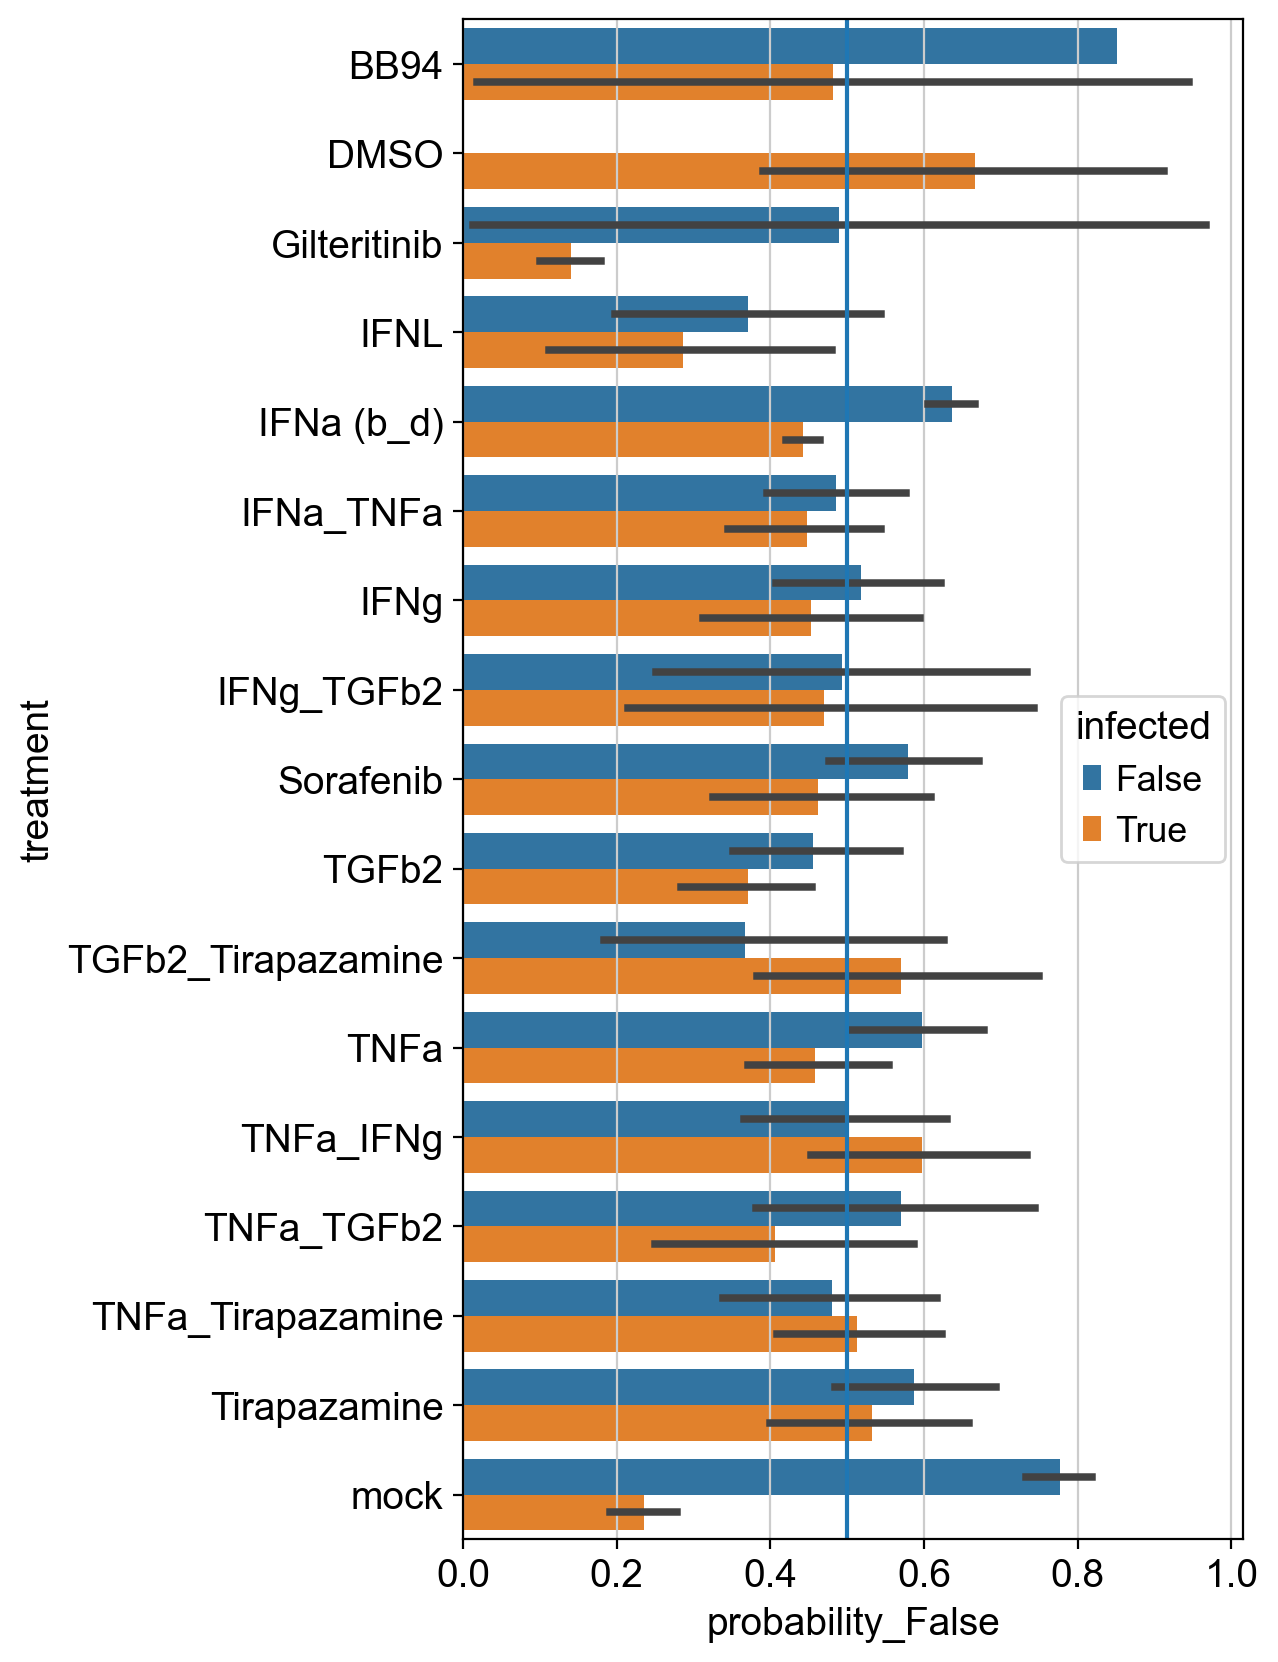

In [39]:
# # among goblet cells, IFNa had the most distinct effect in infected vs. uninfected cells
# plt.figure(figsize=(5, 10))
# sns.barplot(data=df[df.cell_type == 'goblet'], x='probability_False', y='treatment', hue='infected')
# plt.axvline(.5)

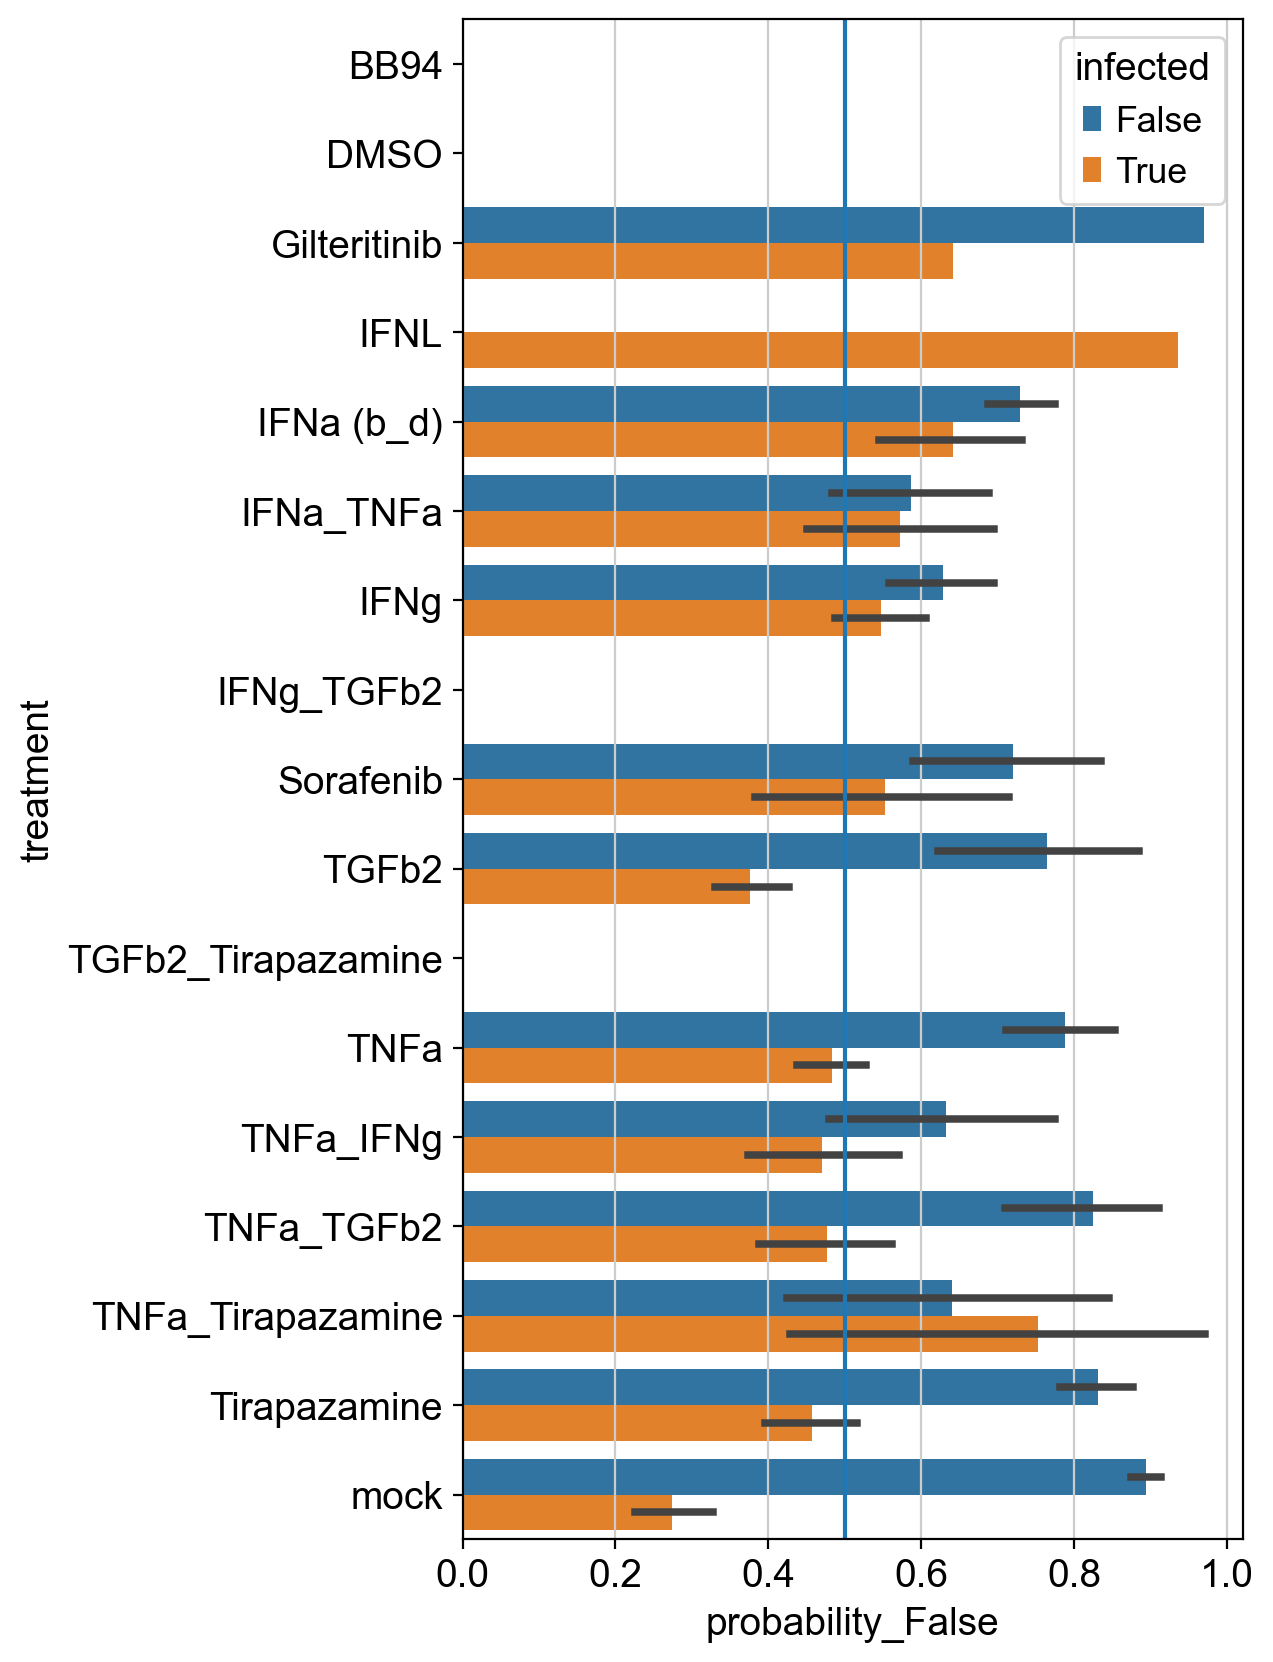

In [107]:
plt.figure(figsize=(5, 10))
sns.barplot(data=df[df.leiden == '20.1'], x='probability_False', y='treatment', hue='infected')
plt.axvline(.5)

Can we identify a bystander population?

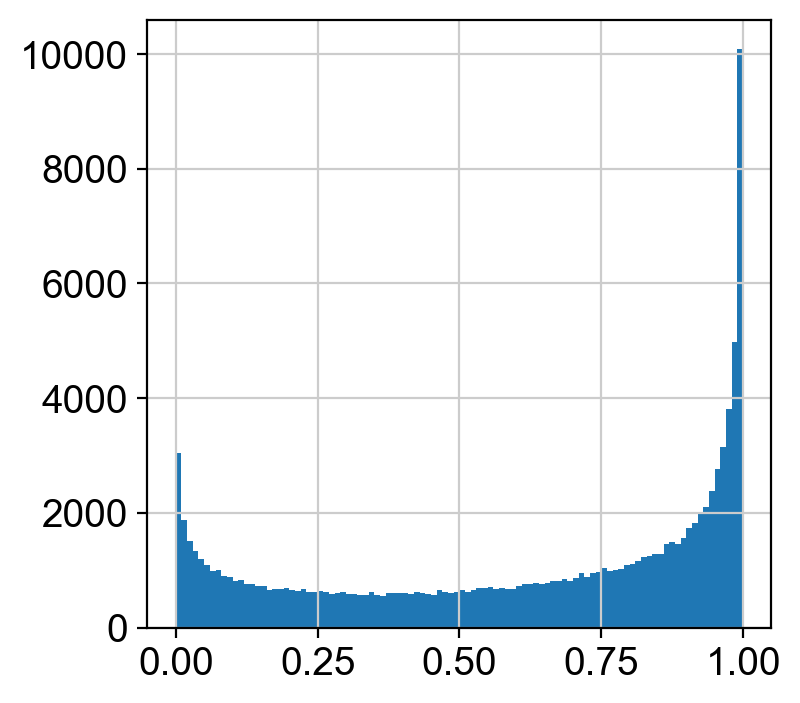

In [148]:
plt.hist(adata[adata.obs.infected == 'True'].obs.probability_True.values, bins=100);

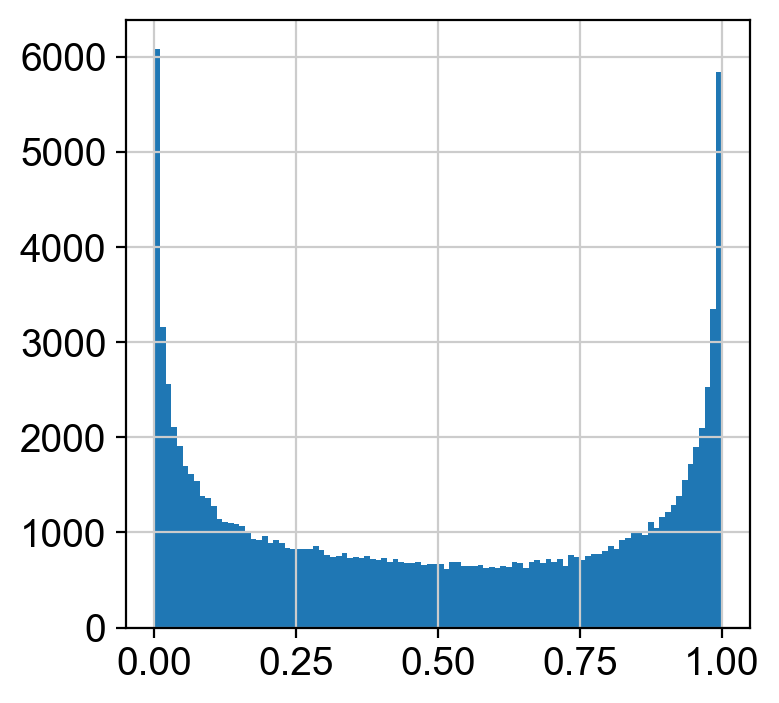

In [149]:
plt.hist(adata[adata.obs.infected == 'False'].obs.probability_True.values, bins=100);

## with a regression instead of a classifier

Make sure to take out the explanatory variables: the viral genes from which `viral_counts` was derived.

TODO: run with cross-validation

In [14]:
adata = adata[:, :-22]  # strangely, the classifier is still incapable of a perfect prediction even with these variables included

In [15]:
%%time
lasso = Lasso(alpha=.01)
lasso.fit(
    adata[adata.obs['treatment'] == 'mock'].X.toarray(),
    adata[adata.obs['treatment'] == 'mock'].obs['viral_counts'].values
)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e+07, tolerance: 5.055e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


CPU times: user 40min 41s, sys: 46.6 s, total: 41min 27s
Wall time: 4min 36s


Lasso(alpha=0.01)

In [16]:
# check on training - again should have a hold out
lasso.score(
    adata[adata.obs['treatment'] == 'mock'].X.toarray(),
    adata[adata.obs['treatment'] == 'mock'].obs['viral_counts'].values
)

0.4305726054936899

In [19]:
%%time
adata.obs['predicted_viral_count'] = lasso.predict(adata.X.toarray())

CPU times: user 11.6 s, sys: 10.5 s, total: 22.1 s
Wall time: 16.6 s


In [20]:
df = adata.obs.copy()

<AxesSubplot:xlabel='predicted_viral_count', ylabel='treatment'>

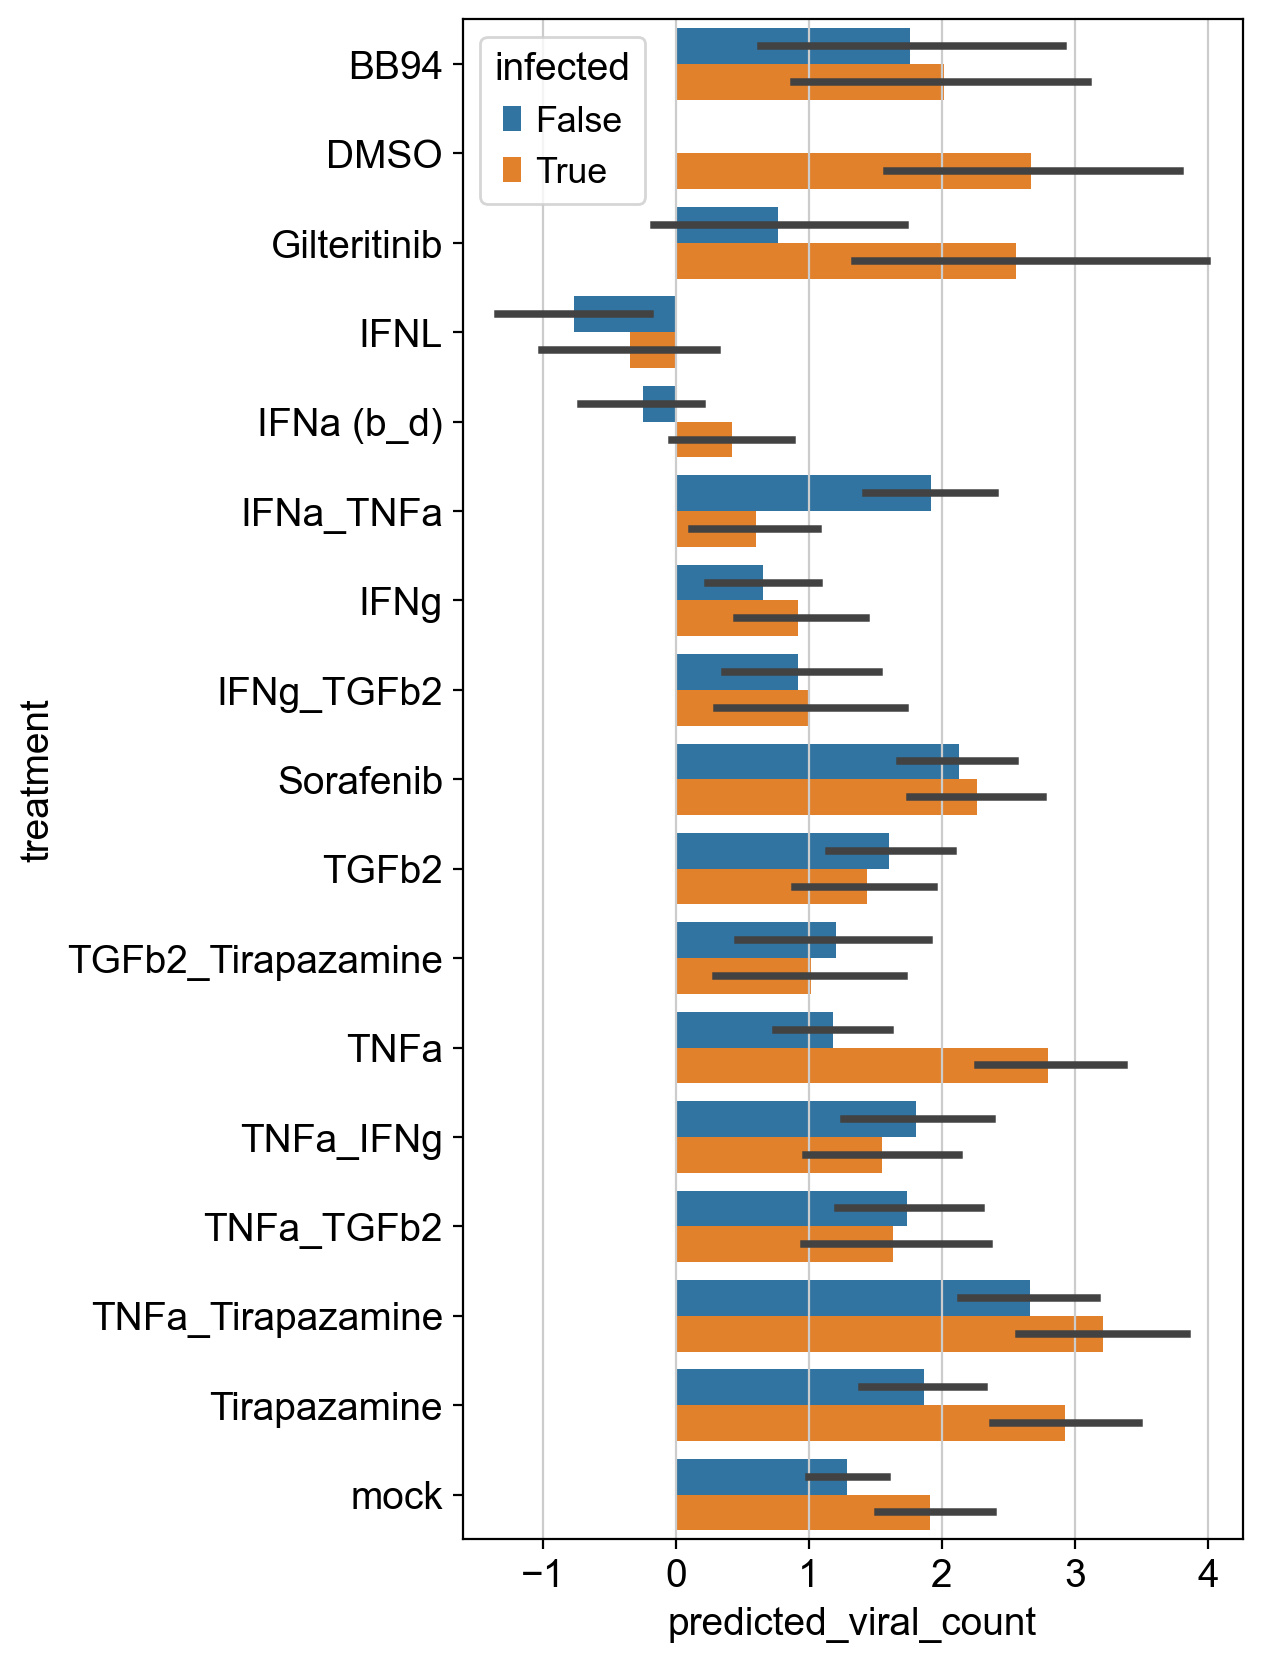

In [21]:
plt.figure(figsize=(5, 10))
sns.barplot(data=df, x='predicted_viral_count', y='treatment', hue='infected')

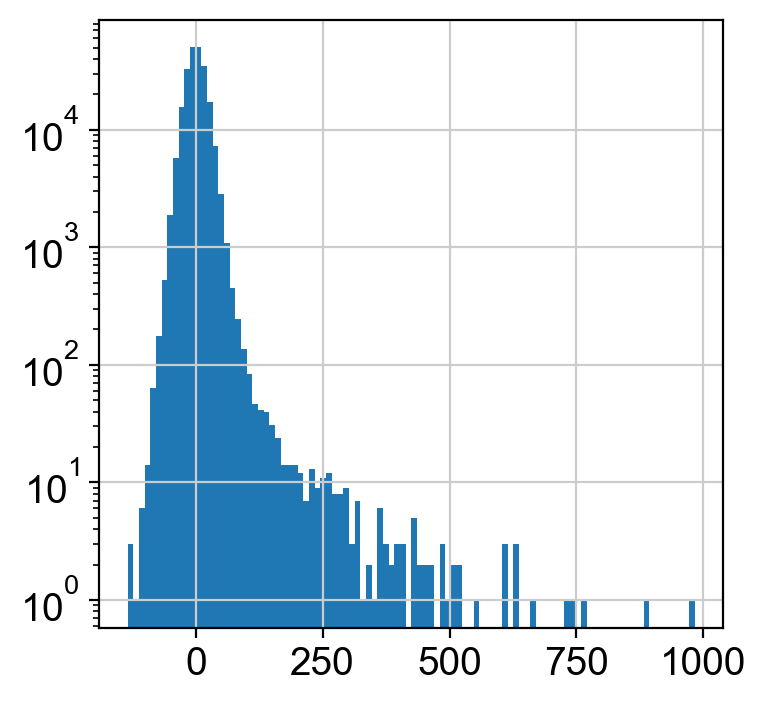

In [22]:
plt.hist(df.predicted_viral_count.values, bins=100)
plt.yscale('log');

<AxesSubplot:xlabel='predicted_viral_count', ylabel='treatment'>

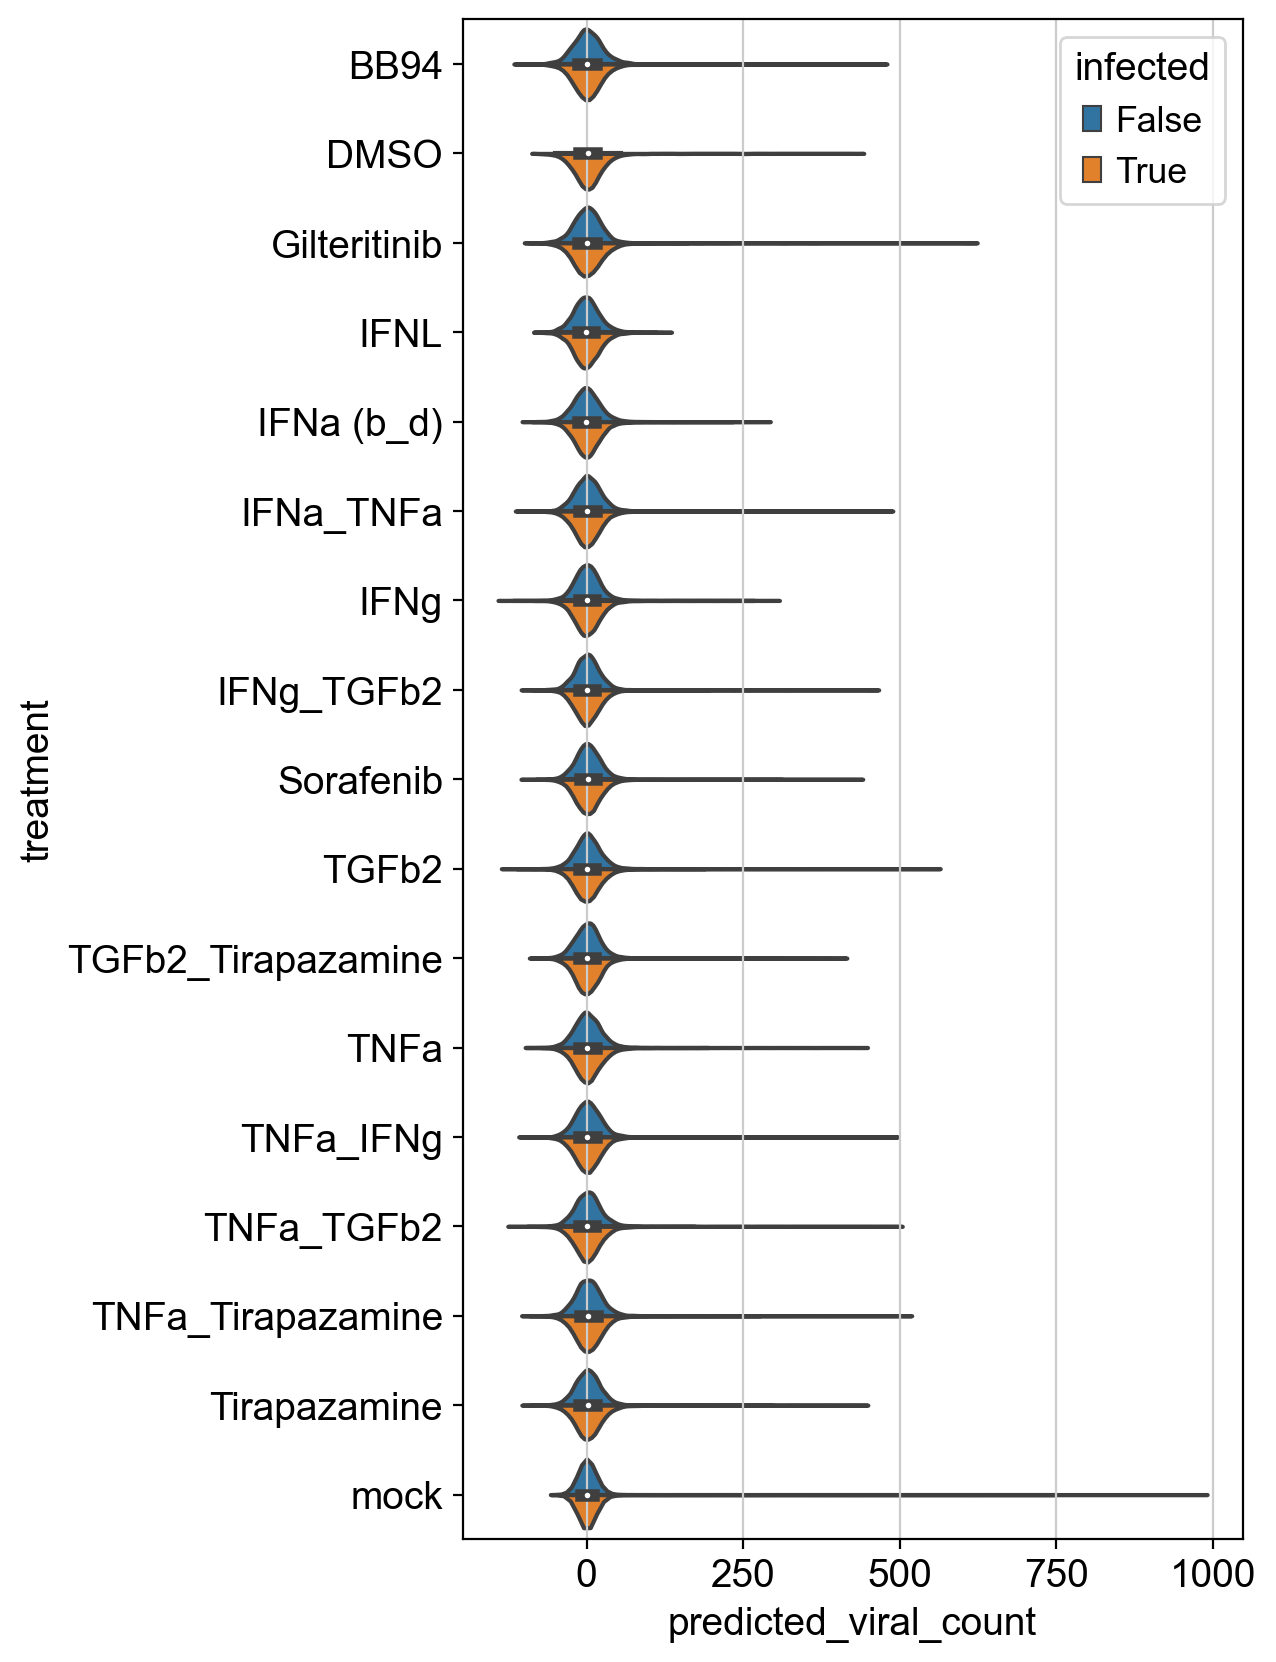

In [37]:
plt.figure(figsize=(5, 10))
sns.violinplot(data=df, x='predicted_viral_count', y='treatment', hue='infected', split=True)
# plt.xscale('log')

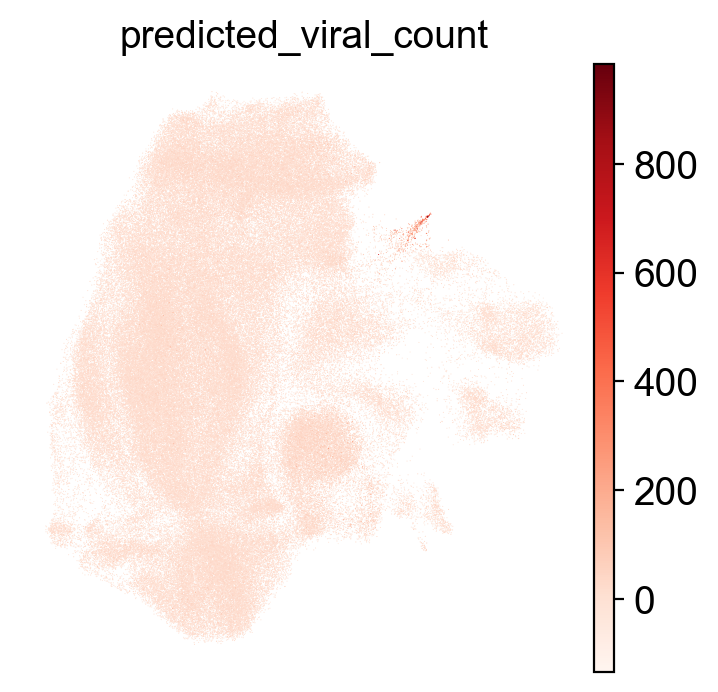

In [24]:
sc.pl.umap(adata, color='predicted_viral_count')

When it comes to the live virus infection signal, we see that only BB94 and Sorafenib treatment look somewhat similar to infection - the others don't! So, the gene set for this is fairly specific.

IFNL is truly confusing... what does "opposite" gene expression even mean?

### Interpret the model

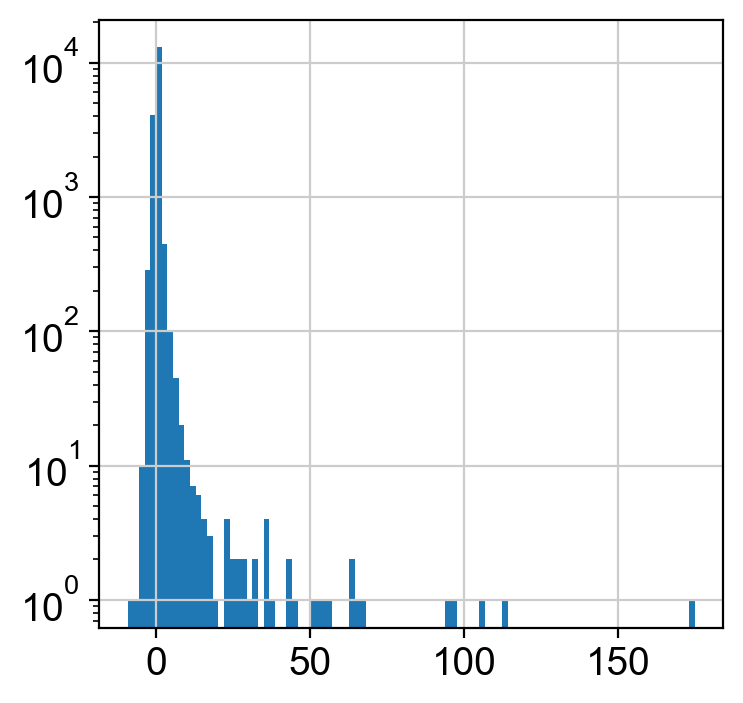

In [46]:
plt.hist(lasso.coef_, bins=100)
plt.yscale('log')

In [55]:
np.quantile(lasso.coef_, .95)

1.457819986343383

In [56]:
enrichr(adata.var_names[lasso.coef_ > 2])

Enrichr API : Get enrichment results: Job Id: {'shortId': '61ed77462d3189d4dbff3c657f6b5998', 'userListId': 46149966}


Rank                              Term name   P-value   Z-score  \
0       1           NF-kappa B signaling pathway  0.000486  3.926852   
1       2       Herpes simplex virus 1 infection  0.000738  2.038063   
2       3   Toll-like receptor signaling pathway  0.000992  3.549223   
3       4                  TNF signaling pathway  0.044012  2.254629   
4       5  RIG-I-like receptor signaling pathway  0.055273  2.548209   
..    ...                                    ...       ...       ...   
233   234                      Parkinson disease  0.985875  0.232426   
234   235                  Wnt signaling pathway  0.991276  0.208566   
235   236                          Thermogenesis  0.992206  0.285398   
236   237                     Huntington disease  0.996962  0.170236   
237   238                 Olfactory transduction  0.999995  0.072818   

     Combined score                                  Overlapping genes  \
0      2.995932e+01  [TNFSF14, PLAU, TRAF3, TNFRSF13C, TRAF1, TICAM...   
1      1.469816e+01  [ZNF829, ZNF627, ZNF846, ZNF548, IL12A, ZNF600...   
2      2.454530e+01  [MAP2K4, IL6, TRAF3, CTSK, IL12A, IRF5, TICAM1...   
3      7.041871e+00  [MAP2K4, IL6, CSF1, TRAF3, TRAF1, PTGS2, MAP3K14]   
4      7.378259e+00              [TRAF3, IL12A, TBKBP1, IKBKE, NFKBIB]   
..              ...                                                ...   
233    3.306387e-03                                           [COX6B2]   
234    1.827577e-03                                         [PRICKLE3]   
235    2.233215e-03                                    [PRKG2, COX6B2]   
236    5.179092e-04                                           [COX6B2]   
237    3.728608e-07                                            [PRKG2]   

     Adjusted p-value  Old p-value  Old adjusted p-value  
0            0.078707            0                     0  
1            0.078707            0                     0  
2            0.078707            0                     0  
3            0.998744            0                     0  
4            0.998744            0                     0  
..                ...          ...                   ...  
233          0.999995            0                     0  
234          0.999995            0                     0  
235          0.999995            0                     0  
236          0.999995            0                     0  
237          0.999995            0                     0  

[238 rows x 9 columns]

### Score on subsets

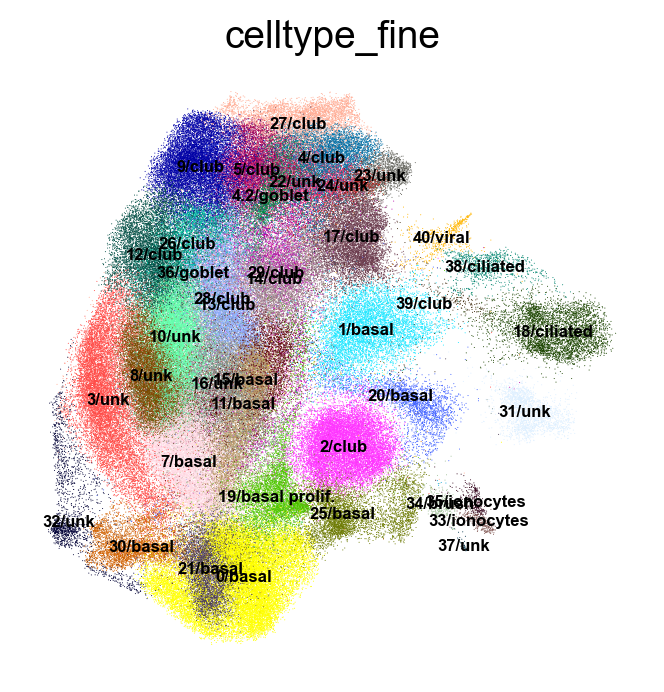

In [36]:
sc.pl.umap(adata, color='celltype_fine', legend_loc='on data', legend_fontsize=6)

<AxesSubplot:xlabel='predicted_viral_count', ylabel='celltype_fine'>

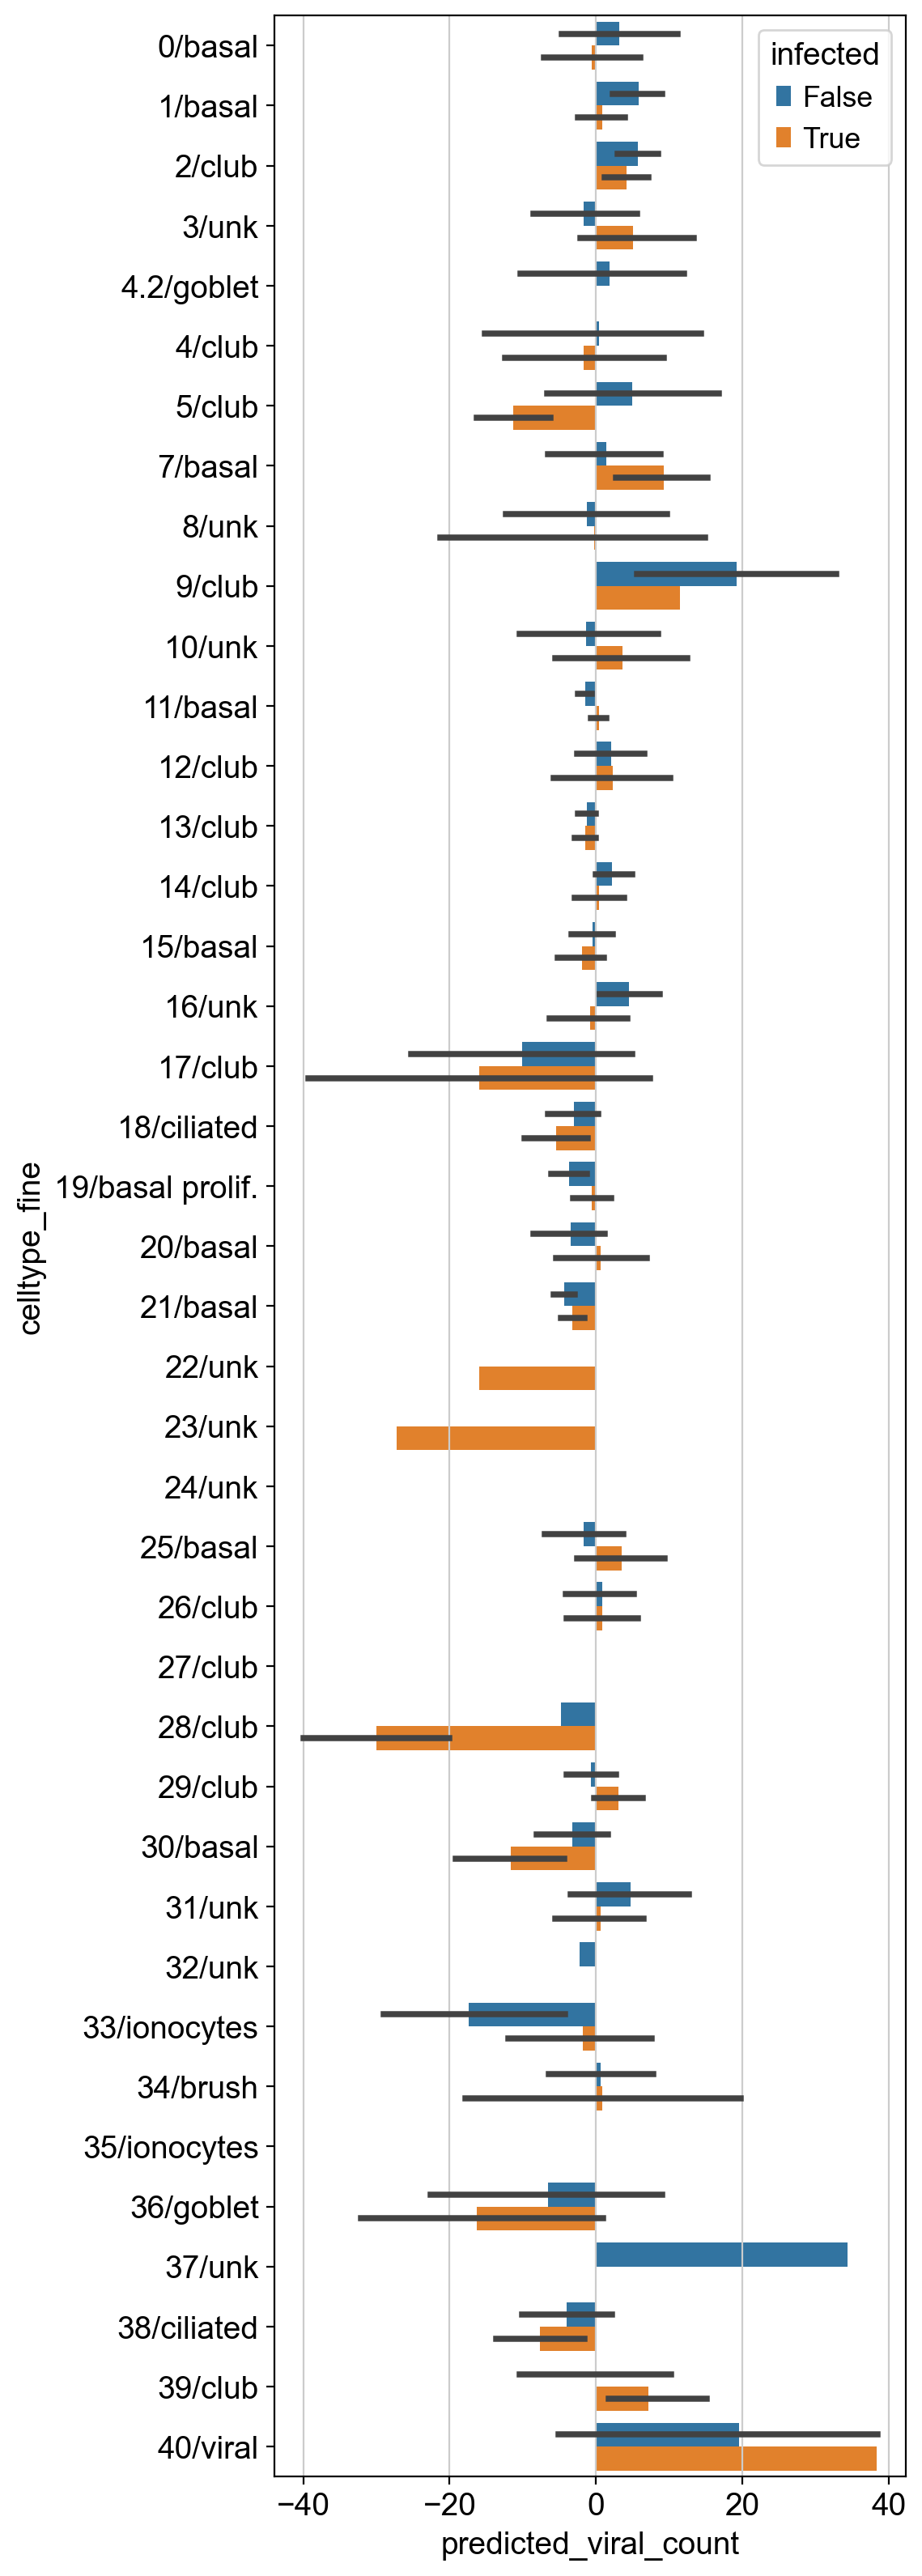

In [33]:
plt.figure(figsize=(5, 20))
sns.barplot(data=df[df.treatment == 'IFNL'], x='predicted_viral_count', y='celltype_fine', hue='infected')